# Modeling
##### _Author: Calvin Chi_

---

# Introduction
In the modeling stage, we are going to run the following machine learning algorithms to predict the probability of player churn:

1. K-Nearest Neighbors
2. Support Vector Machine (SVM)
3. Logistic Regression
4. Random Forest
5. Quadratic Discriminant Analysis (QDA)
6. Neural Network

Our dataset will come from the dataset created during [exploratory data analysis](https://github.com/CalvinTChi/Player-Churn-Prediction/blob/master/Calvin/Exploratory_Data_Analysis.ipynb), where poor features were removed and new useful features were created. Then, we will select a subset of total features determined to be the most useful for classification from our exploratory data anaylsis stage. 

Since there is a class imbalance in our dataset, certain algorithms such as QDA may benefit from a boostrapped dataset. Hence, we will also create a boostrapped dataset such that we have each class represented by roughly 50% of the dataset.

Our positive class is non-churn players and our negative class is churn players. We are much more interested in correctly identifying positive classes. However, having a lower true negative rate will not hinder our goal of encouraging players unlikely to churn to pay. Thus, we would like to maximize recall. However, because we can arbitrarily adjust our classification threshold to meet desired recall, our optimization objective cannot be purely recall. In classification tasks, there is a tradeoff between precision and recall, so our optimization objective is to maximize the area under the precision-recall curve.

# Data Preparation
We will first start by loading packages and defining the locations of our data and output directories.

In [7]:
import warnings
import pandas as pd
import numpy as np
import pickle
from sklearn import grid_search
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.cross_validation import train_test_split
import copy

dataDir = "data/"
fileDir = "../data/payerChurnData.csv"
outputDir = "output/"
warnings.filterwarnings('ignore')

Load the data

In [216]:
Xtrain = pickle.load(open(dataDir + "Xtrain.p", "rb"))
ytrain = pickle.load(open(dataDir + "ytrain.p", "rb"))
Xtest = pickle.load(open(dataDir + "Xtest.p", "rb"))
ytest = pickle.load(open(dataDir + "ytest.p", "rb"))

In our dataset we have 83.2% churn-players and 16.8% non-churn players, so we may need to bootstrap our non-churn playes so that we have roughly 50% samples from each class.

In [152]:
# Bootstrap training dataset 
negIdx = np.where(ytrain == 0)[0]
posIdx = np.where(ytrain == 1)[0]
posTot = len(negIdx) - len(posIdx)

# Sample with replacement 
BSidx = np.random.choice(posIdx, posTot)
# Randomly shuffle our training samples
idx = np.random.permutation(np.hstack((negIdx, posIdx, BSidx)))
XtrainBS = Xtrain.iloc[idx, :]
ytrainBS = ytrain.iloc[idx]
print("Bootstrapped training sample dimensions")
print(XtrainBS.shape)

# Bootstrap test dataset
negIdx = np.where(ytest == 0)[0]
posIdx = np.where(ytest == 1)[0]
posTot = len(negIdx) - len(posIdx)

# Sample with replacement
BSidx = np.random.choice(posIdx, posTot)
# Randomly shuffle our training samples
idx = np.random.permutation(np.hstack((negIdx, posIdx, BSidx)))
XtestBS = Xtest.iloc[idx, :]
ytestBS = ytest.iloc[idx]
print("Bootstrapped test sample dimensions")
print(XtestBS.shape)

Bootstrapped training sample dimensions
(97086, 270)
Bootstrapped test sample dimensions
(24280, 270)


# K-Nearest Neighbors

In [5]:
from sklearn.neighbors import KNeighborsClassifier

### Non-Bootstrap Dataset
Subset our dataset based on selected attributes

In [8]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = copy.deepcopy(Xtrain.ix[:, attributes])
XtestSub = copy.deepcopy(Xtest.ix[:, attributes])
print(XtrainSub.shape)
print(XtestSub.shape)

(58369, 29)
(14593, 29)


Scale the data

In [9]:
Xtrain = pp.scale(XtrainSub)
Xtest = pp.scale(XtestSub)

kNN tuning for number of neighbors $n$

In [10]:
knn = KNeighborsClassifier()
neighbors = [2**i for i in range(2, 11)]
parameters = {'n_neighbors':neighbors}
clf = grid_search.GridSearchCV(knn, parameters, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 336.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [4, 8, 16, 32, 64, 128, 256, 512, 1024]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

In [11]:
gridScores = clf.grid_scores_
clf.grid_scores_

[mean: 0.57016, std: 0.01000, params: {'n_neighbors': 4},
 mean: 0.60055, std: 0.00987, params: {'n_neighbors': 8},
 mean: 0.61836, std: 0.01053, params: {'n_neighbors': 16},
 mean: 0.62715, std: 0.01019, params: {'n_neighbors': 32},
 mean: 0.62924, std: 0.00939, params: {'n_neighbors': 64},
 mean: 0.62762, std: 0.00983, params: {'n_neighbors': 128},
 mean: 0.62374, std: 0.00876, params: {'n_neighbors': 256},
 mean: 0.61626, std: 0.00992, params: {'n_neighbors': 512},
 mean: 0.60891, std: 0.01016, params: {'n_neighbors': 1024}]

Gather all the mean area under the PR curve scores from hyperparameter tuning:

In [12]:
means = []
for item in gridScores: 
    means.append(item[1])

Now make a plot of the area under the PR curve score against the hyperparameters $n$:

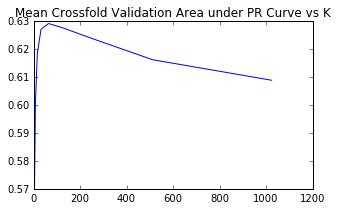

In [13]:
%matplotlib inline
plt.figure(figsize=(5, 3))
plt.title("Mean Crossfold Validation Area under PR Curve vs K")
plt.plot(neighbors, means)
plt.show()

So the best parameter is...

In [14]:
print("Best parameter: ")
print(clf.best_params_)

Best parameter: 
{'n_neighbors': 64}


It looks like `k = 64` is the best parameter for k-NN. Let us evaluate its performance on the test set. First predict probability and output area under the ROC curve.

In [15]:
knn = KNeighborsClassifier(n_neighbors=64)
knn.fit(Xtrain, ytrain)
prob = knn.predict_proba(Xtest)[:, 1]

The area under the PR curve for the test set is:

In [16]:
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.622584800895


Let us visualize the PR curve from our output probabilities:

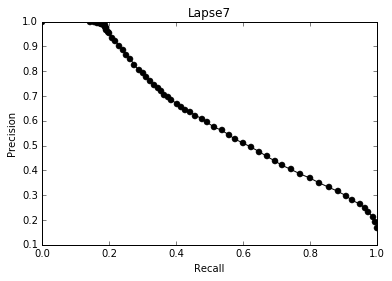

In [17]:
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

And also evaluate the accuracy

In [18]:
pred = knn.predict(Xtest)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.867539231138


Finally, let us visualize the confusion matrix:

In [19]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,11765,375,12140
1,1558,895,2453
All,13323,1270,14593


According to the confusion matrix, at 50% classification threshold, we have a relatively low recall of 0.36, but high precision of 0.70. If we only had the kNN model trained on the non-bootstrap sample, then we will want to decrease the non-churn player classification threshold in order to obtain higher recall. However, this will inevitably cause a tradeoff with precision. From the PR curve plotted above, a 90% recall corresponds to roughly 30% precision. 

### Bootstrap Dataset

Subset our dataset based on selected attributes

In [24]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = copy.deepcopy(XtrainBS.ix[:, attributes])
XtestSub = copy.deepcopy(XtestBS.ix[:, attributes])
print(XtrainSub.shape)
print(XtestSub.shape)

(97086, 29)
(24280, 29)


First scale the data

In [26]:
Xtrain = pp.scale(XtrainSub)
Xtest = pp.scale(XtestSub)

Do a hyperparameter search

In [27]:
knn = KNeighborsClassifier()
neighbors = [2**i for i in range(5, 11)]
parameters = {'n_neighbors':neighbors}
clf = grid_search.GridSearchCV(knn, parameters, scoring='average_precision', cv=3, verbose=True)
clf.fit(Xtrain, ytrainBS)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 49.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [32, 64, 128, 256, 512, 1024]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

Print out the scores from hyperparameter search

In [28]:
clf.grid_scores_

[mean: 0.53218, std: 0.00183, params: {'n_neighbors': 32},
 mean: 0.53216, std: 0.00060, params: {'n_neighbors': 64},
 mean: 0.53024, std: 0.00103, params: {'n_neighbors': 128},
 mean: 0.52542, std: 0.00139, params: {'n_neighbors': 256},
 mean: 0.51979, std: 0.00131, params: {'n_neighbors': 512},
 mean: 0.51265, std: 0.00273, params: {'n_neighbors': 1024}]

It looks like 32 neighbors is best for the bootstrap sample. Let us evaluate the model on the test set.

In [31]:
knn = KNeighborsClassifier(n_neighbors=32)
knn.fit(Xtrain, ytrainBS)
predProb = knn.predict_proba(Xtest)[:, 1]

The area under the PR curve for the test set is:

In [32]:
area = average_precision_score(ytestBS, predProb)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.521314525594


Let us visualize the PR curve from our output probabilities:

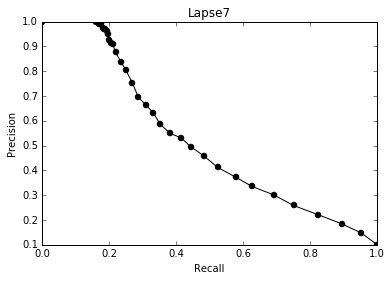

In [34]:
precision, recall, thresholds = precision_recall_curve(ytestBS, predProb)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

And also evaluate the accuracy:

In [36]:
pred = knn.predict(Xtest)
print("Accuracy: ")
print(np.mean(pred == ytestBS))

Accuracy: 
0.917257001647


Confusion matrix

In [38]:
pd.crosstab(ytestBS, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,21611,216,21827
1,1793,660,2453
All,23404,876,24280


k-NN performs worse for the bootstrapped dataset compared to the original dataset. If we were to incorporate our k-NN model to our final results, we would choose the one trained on the original dataset.

# SVM

Import the SVM package

In [62]:
from sklearn.svm import SVC

Scale the data:

In [217]:
features = Xtrain.columns.values
Xtrain = pd.DataFrame(pp.scale(Xtrain))
Xtrain.columns = features
Xtest = pd.DataFrame(pp.scale(Xtest))
Xtest.columns = features

Subset the data based on selected attributes from decision tree

In [218]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = Xtrain.ix[:, attributes]
XtestSub = Xtest.ix[:, attributes]
print(XtrainSub.shape)
print(XtestSub.shape)

(58369, 29)
(14593, 29)


Below is sample code for hyperparameter tuning for SVM. Hyperparameter tuning is not run in Juypter Notebook to reduce runtime. We have prior knowledge that a `rbf` kernel works better than a `polynomial` kernel.
```python
svm = SVC(probability=True)
Cs = [2**i for i in range(-3, 4)]
kernels = ['poly', 'rbf']
degrees = [2, 3]
parameters = {'C':Cs, 'kernel':kernels, 'degree':degrees}
clf = grid_search.GridSearchCV(svm, parameters, cv=3, n_jobs=2, 
	scoring='average_precision', verbose=True)
clf.fit(XtrainSub, ytrain)
```

Load scores after turning

In [109]:
clf2 = pickle.load(open(outputDir + "svmTune.p", "rb"))

Print out the scores

In [110]:
clf2.grid_scores_

[mean: 0.51562, std: 0.01984, params: {'C': 0.25},
 mean: 0.51209, std: 0.01423, params: {'C': 0.5},
 mean: 0.50464, std: 0.00931, params: {'C': 1},
 mean: 0.49618, std: 0.00293, params: {'C': 2},
 mean: 0.48328, std: 0.00118, params: {'C': 4},
 mean: 0.46871, std: 0.00614, params: {'C': 8},
 mean: 0.45674, std: 0.00793, params: {'C': 16},
 mean: 0.44262, std: 0.00613, params: {'C': 32},
 mean: 0.43170, std: 0.00202, params: {'C': 64},
 mean: 0.42833, std: 0.00431, params: {'C': 128}]

It appears that C=0.25 is the best parameter.

Train
```python 
svm = SVC(probability=True, kernel='rbf', C=0.25)
svm.fit(XtrainSub, ytrain)
```

In [222]:
svm = pickle.load(open(outputDir + "svm.p", "rb"))

Predict on test set

In [223]:
pred = svm.predict(XtestSub)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.598026451038


Evaluate area under the PR curve

In [224]:
prob = svm.predict_proba(XtestSub)[:, 1]
area = average_precision_score(ytest, prob)
print("Area under PR Curve")
print(area)

Area under PR Curve
0.439737616813


Confusion matrix

In [225]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,6460,5680,12140
1,186,2267,2453
All,6646,7947,14593


Plot the PR curve

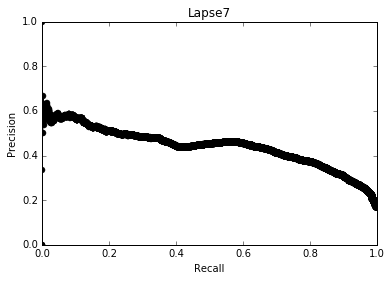

In [226]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

Save the predictions

In [227]:
pickle.dump(prob, open(outputDir + "svm.prediction.p", 'wb'))

If we were to reach 90% recall, we would have roughly 30% precision. SVM appears to be a viable algorithm for our problem.

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

Scale the data:

In [45]:
features = Xtrain.columns.values
Xtrain = pd.DataFrame(pp.scale(Xtrain))
Xtrain.columns = features
Xtest = pd.DataFrame(pp.scale(Xtest))
Xtest.columns = features

Subset the data based on selected attributes from decision tree

In [46]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = Xtrain.ix[:, attributes]
XtestSub = Xtest.ix[:, attributes]

Tune the model

In [94]:
Cs = [2**i for i in range(-4, 8)]
lr = LogisticRegression(class_weight={0:0.1, 1:0.9})
parameters = {'C':Cs}
clf = grid_search.GridSearchCV(lr, parameters, cv=3, scoring='average_precision', 
                               verbose=True)
clf.fit(Xtrain, ytrain)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=True)

Print out the scores

In [99]:
gridScores = clf.grid_scores_
gridScores

[mean: 0.51020, std: 0.00847, params: {'C': 0.0625},
 mean: 0.51007, std: 0.00832, params: {'C': 0.125},
 mean: 0.50986, std: 0.00811, params: {'C': 0.25},
 mean: 0.50971, std: 0.00799, params: {'C': 0.5},
 mean: 0.50952, std: 0.00796, params: {'C': 1},
 mean: 0.50938, std: 0.00796, params: {'C': 2},
 mean: 0.50931, std: 0.00795, params: {'C': 4},
 mean: 0.50926, std: 0.00795, params: {'C': 8},
 mean: 0.50924, std: 0.00795, params: {'C': 16},
 mean: 0.50924, std: 0.00795, params: {'C': 32},
 mean: 0.50923, std: 0.00795, params: {'C': 64},
 mean: 0.50923, std: 0.00795, params: {'C': 128}]

It looks like the best regularization parameter `C` is 0.0625. Instead of training one logistic regression model, let us perform adaboost with multiple logistic regression models. In adaboost, models are trained successively, and misclassified samples from the previous model are weighted more heavily in subsequent models. The final classifier is a weighted sum of the multiple classifiers. 

In [54]:
lr = LogisticRegression(C=0.0625, class_weight={0:0.1, 1:0.90})
ada = AdaBoostClassifier(base_estimator=lr, n_estimators=50)
ada.fit(XtrainSub, ytrain)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=0.0625, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

Output the area under the PR curve

In [55]:
predProb = ada.predict_proba(XtestSub)[:, 1]
pr = average_precision_score(ytest, predProb)
print("Area under PR curve: ")
print(pr)

Area under PR curve: 
0.480295887763


And plot the PR curve

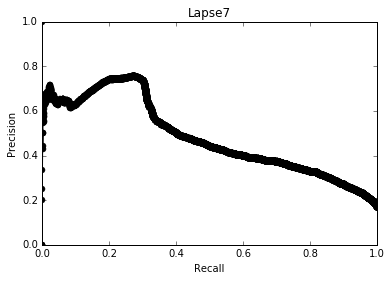

In [59]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, predProb)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

And evaluate the accuracy of the model

In [56]:
pred = ada.predict(XtestSub)
print("Accuracy: ")
print(np.mean(pred == ytest))

Accuracy: 
0.507160967587


Finally, output the confusion matrix

In [57]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,5108,7032,12140
1,160,2293,2453
All,5268,9325,14593


Save the predictions

In [105]:
pickle.dump(predProb, open(outputDir + "logistic.prediction.p", 'wb'))

# Random Forests

Load the random forest package

In [174]:
from sklearn.ensemble import RandomForestClassifier

Hyperparameter turning for number of trees and class weights. Actual code run in `code/RandomForest.py`

```python
n_estimators = list(range(30, 110, 10))
class_weights = [{0:0.2, 1:0.8}, {0:0.15, 1:0.85}, {0:0.1, 1:0.9}, {0:0.05,  1:0.95}]
parameters = {'n_estimators':n_estimators, 'class_weight':class_weights}
rf = RandomForestClassifier(max_depth=6)
clf = grid_search.GridSearchCV(rf, parameters, cv=3, scoring='average_precision', 
                               verbose=True)
clf.fit(Xtrain, ytrain)
```

In [147]:
clf = pickle.load(open(outputDir + "RandomForestTune.p", 'rb'))

What are the best parameters

In [148]:
clf.best_params_

{'class_weight': {0: 0.05, 1: 0.95}, 'n_estimators': 50}

Train and assess accuracy

In [71]:
clf = RandomForestClassifier(n_estimators=50, class_weight={0:0.1, 1:0.90}, max_depth=8)
clf.fit(Xtrain, ytrain)
pred = clf.predict(Xtest)
np.mean(pred == ytest)

0.71308161447269236

Assess area under PR curve

In [72]:
prob = clf.predict_proba(Xtest)[:, 1]
pr = average_precision_score(ytest, prob)
print("Area under PR curve: ")
print(pr)

Area under PR curve: 
0.662034046921


Plot the PR curve:

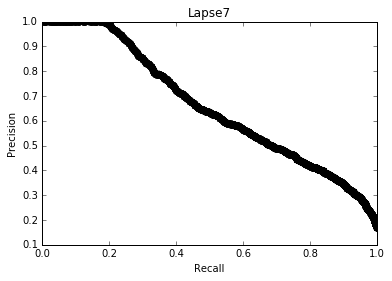

In [73]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

Confusion matrix

In [74]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,8235,3905,12140
1,282,2171,2453
All,8517,6076,14593


Save the result

In [75]:
pickle.dump(prob, open(outputDir + "RandomForest.prediction.p", 'wb'))

# Quadratic Discriminant Analysis

In [109]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

For QDA, bootstrapping our positive class could help because it could make our Gaussian densities "tigher", so we will train using the bootsrapped dataset.

In [205]:
attributes = pickle.load(open(outputDir + "attributes.p", "rb"))
XtrainSub = copy.deepcopy(XtrainBS.ix[:, attributes])
XtestSub = copy.deepcopy(Xtest.ix[:, attributes])

Train and predict

In [206]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(XtrainSub, ytrainBS)
pred = qda.predict(XtestSub)
print("Accuracy: ")
print(np.mean(pred == ytest))
prob = qda.predict_proba(XtestSub)[:, 1]
pr = average_precision_score(ytest, prob)
print("Area under precision-recall curve: ")
print(pr)

Accuracy: 
0.50023984102
Area under recall curve: 
0.593968928251


Let us plot the PR curve

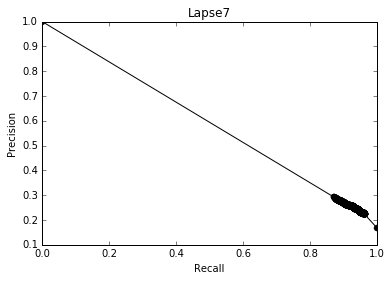

In [207]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

Confusion matrix

In [208]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4996,7144,12140
1,149,2304,2453
All,5145,9448,14593


Save the predictions

In [209]:
pickle.dump(prob, open(outputDir + "QDA.prediction.p", 'wb'))

# Neural Network

In [4]:
from sklearn.neural_network import MLPClassifier

Assess the dimenions of our input:

In [5]:
Xtrain.shape

(58369, 153)

We are going to use a one layer neural network with number of neurons equal to the average betweent the input and output neurons, which is 78. 

```python
nn = Classifier(
    layers=[
        Layer("Rectifier", units=78),
        Layer("Softmax")],
    learning_rate=0.001,
    verbose=True,
    n_iter=20)
```

Scale the data

In [144]:
Xtrain = pp.scale(Xtrain)
Xtest = pp.scale(Xtest)

Train

```python
nn.fit(Xtrain, ytrain)
```

Load the trained model

In [50]:
nn = pickle.load(open(outputDir + "nn.p", 'rb'))

Predict and assess accuracy

In [51]:
pred = nn.predict(Xtest)
np.mean(pred == ytest)

0.22757486466113891

Output area under the curve

In [52]:
prob = nn.predict_proba(Xtest)[:, 1]
pr = average_precision_score(ytest, prob)
print("Area under precision-recall curve: ")
print(pr)

Area under recall curve: 
0.415208407798


Confusion matrix:

In [53]:
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1013,11164,12177
1,108,2308,2416
All,1121,13472,14593


Plot the PR curve

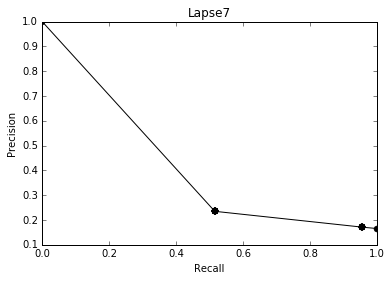

In [54]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, prob)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

At stage, artificial neural network does not perform as well as other machine learning algorithms and will be omitted from the final result.

# Ensembling
According to the wisdom of the crowd theory, the average of multiple weak classifiers outperforms a single strong classifier. Our best performing machine learning algorithms are:

1. SVM
2. Random Forest
3. Logistic Regression
4. QDA

Of these algorithms, random forest performs the best. Let us average the predicted probabilities from these 4 models to see if performance improves over that achieved from random forest alone. First load the predictions.

In [229]:
svm = pickle.load(open(outputDir + "svm.prediction.p", 'rb'))
randomForest = pickle.load(open(outputDir + "RandomForest.prediction.p", 'rb'))
logisticRegression = pickle.load(open(outputDir + "logistic.prediction.p", 'rb'))
qda = pickle.load(open(outputDir + "QDA.prediction.p", 'rb'))

And we simply average the probabilities

In [242]:
probs = (svm + randomForest + logisticRegression + qda) / 4

Let us evaluate the area under the precision-recall curve

In [243]:
pr = average_precision_score(ytest, probs)
print("Area under precision-recall curve: ")
print(pr)

Area under precision-recall curve: 
0.474979314871


As well as plot the precision-recall curve

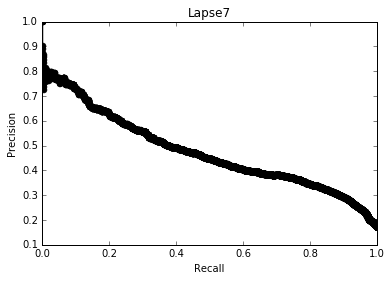

In [244]:
%matplotlib inline
precision, recall, thresholds = precision_recall_curve(ytest, probs)
plt.plot(recall, precision, "o-", color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Lapse7")
plt.show()

It looks like ensembling does not outperform random forests, which has an area under the curve of 66%. Based on our modeling result, random forest alone is the best classifier for player churn.